In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv(r'C:\Users\user\Desktop\datasets\healthcare_facilities.csv', encoding='latin1')

In [3]:
df.shape

(10013, 13)

In [4]:
df.ndim

2

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10013 entries, 0 to 10012
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OBJECTID    10013 non-null  int64  
 1   Facility_N  10013 non-null  object 
 2   Type        10013 non-null  object 
 3   Owner       10013 non-null  object 
 4   County      10013 non-null  object 
 5   Sub_County  10013 non-null  object 
 6   Division    10013 non-null  object 
 7   Location    10013 non-null  object 
 8   Sub_Locati  10013 non-null  object 
 9   Constituen  10013 non-null  object 
 10  Nearest_To  10013 non-null  object 
 11  Latitude    10013 non-null  float64
 12  Longitude   10013 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 1017.1+ KB


In [6]:
df.describe()

,OBJECTID,Latitude,Longitude
count,10013.000000,10013.000000,10013.000000
mean,5007.000000,-0.594078,36.723861
std,2890.648457,1.436301,1.633828
min,1.000000,-4.662270,33.927900
25%,2504.000000,-1.267410,35.243630
50%,5007.000000,-0.552485,36.831430
75%,7510.000000,0.094510,37.601720
max,10013.000000,5.307280,41.888340


In [7]:
df.isnull().sum()

OBJECTID      0
Facility_N    0
Type          0
Owner         0
County        0
Sub_County    0
Division      0
Location      0
Sub_Locati    0
Constituen    0
Nearest_To    0
Latitude      0
Longitude     0
dtype: int64

In [2]:
# Drop nulls in latitude and longitude
df = df.dropna(subset=['Latitude', 'Longitude'])

In [3]:
# Use only coordinates for DBSCAN
coords = df[['Latitude', 'Longitude']]

In [4]:
# Scale the features (DBSCAN is distance-based)
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Apply DBSCAN
db = DBSCAN(eps=0.3, min_samples=5)  # tune eps & min_samples
db.fit(coords_scaled)

DBSCAN(eps=0.3)

In [5]:
# Add cluster labels to dataframe
df['DBSCAN_cluster'] = db.labels_

# -1 indicates noise (i.e., outliers)
outliers = df[df['DBSCAN_cluster'] == -1]
inliers = df[df['DBSCAN_cluster'] != -1]

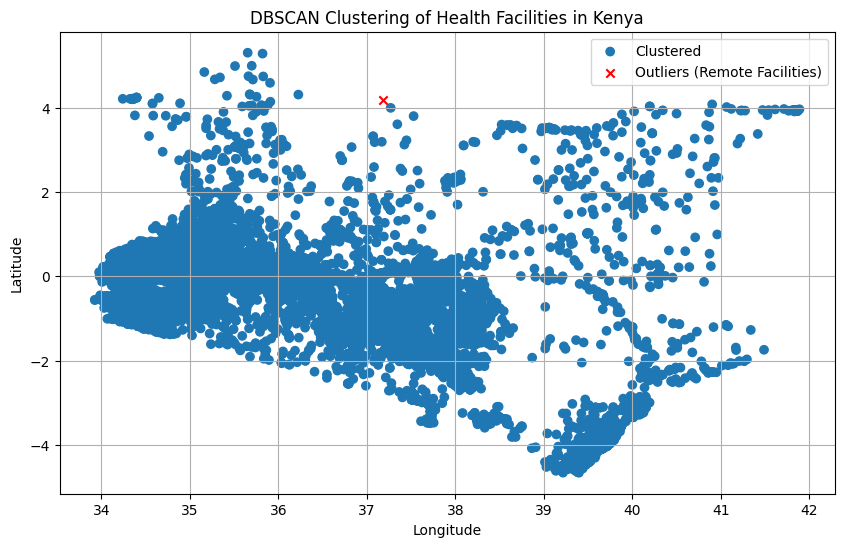

In [6]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(inliers['Longitude'], inliers['Latitude'], c=df[df['DBSCAN_cluster'] != -1]['DBSCAN_cluster'], cmap='tab10', label='Clustered')
plt.scatter(outliers['Longitude'], outliers['Latitude'], c='red', label='Outliers (Remote Facilities)', marker='x')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of Health Facilities in Kenya')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
print(df.keys())

Index(['OBJECTID', 'Facility_N', 'Type', 'Owner', 'County', 'Sub_County',
       'Division', 'Location', 'Sub_Locati', 'Constituen', 'Nearest_To',
       'Latitude', 'Longitude', 'DBSCAN_cluster'],
      dtype='object')


In [7]:
## Identify the ownership of the health facilities

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Step 2: Check relevant columns
df = df[['Facility_N', 'Owner', 'County', 'Latitude', 'Longitude']]

# Step 3: Drop missing values
df = df.dropna()

In [8]:
# Step 4: Encode 'Owner' (categorical) to numeric
le = LabelEncoder()
df['Owner_encoded'] = le.fit_transform(df['Owner'])

In [9]:
# Step 5: Prepare data for clustering
X = df[['Latitude', 'Longitude', 'Owner_encoded']]

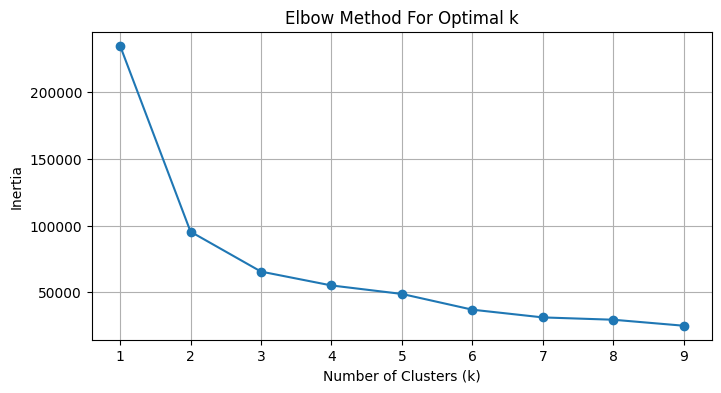

In [10]:
# Step 6: Determine the optimal number of clusters (Elbow method)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow
plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [11]:
# Step 7: Apply KMeans with k=4 (or your chosen k)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

In [12]:
# Step 8: Use PCA for 2D visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
df['PCA1'] = principal_components[:, 0]
df['PCA2'] = principal_components[:, 1]

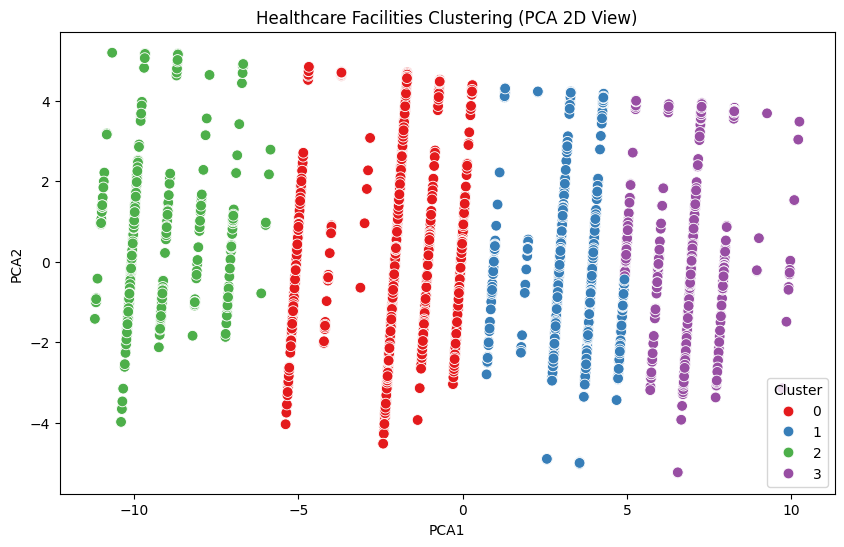

In [13]:
# Step 9: Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=60)
plt.title('Healthcare Facilities Clustering (PCA 2D View)')
plt.legend(title='Cluster')
plt.show()

In [14]:
print(df.groupby('Cluster').size())

Cluster
0    5627
1    2056
2     625
3    1705
dtype: int64


In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Owner_encoded'] = encoder.fit_transform(df['Owner'])

In [19]:
# Group by Cluster and Ownership for Insight

cluster_summary = df.groupby(['Cluster', 'Owner']).size().unstack(fill_value=0)
print(cluster_summary)

Owner    Academic (if registered)  Christian Health Association of Kenya  \
Cluster                                                                    
0                               0                                      0   
1                               0                                      0   
2                              36                                    370   
3                               0                                      0   

Owner    Community  Community Development Fund  Company Medical Service  \
Cluster                                                                   
0                0                           0                        0   
1                0                           0                        0   
2               91                          38                       84   
3                0                           0                        0   

Owner    Humanitarian Agencies  \
Cluster                          
0                       

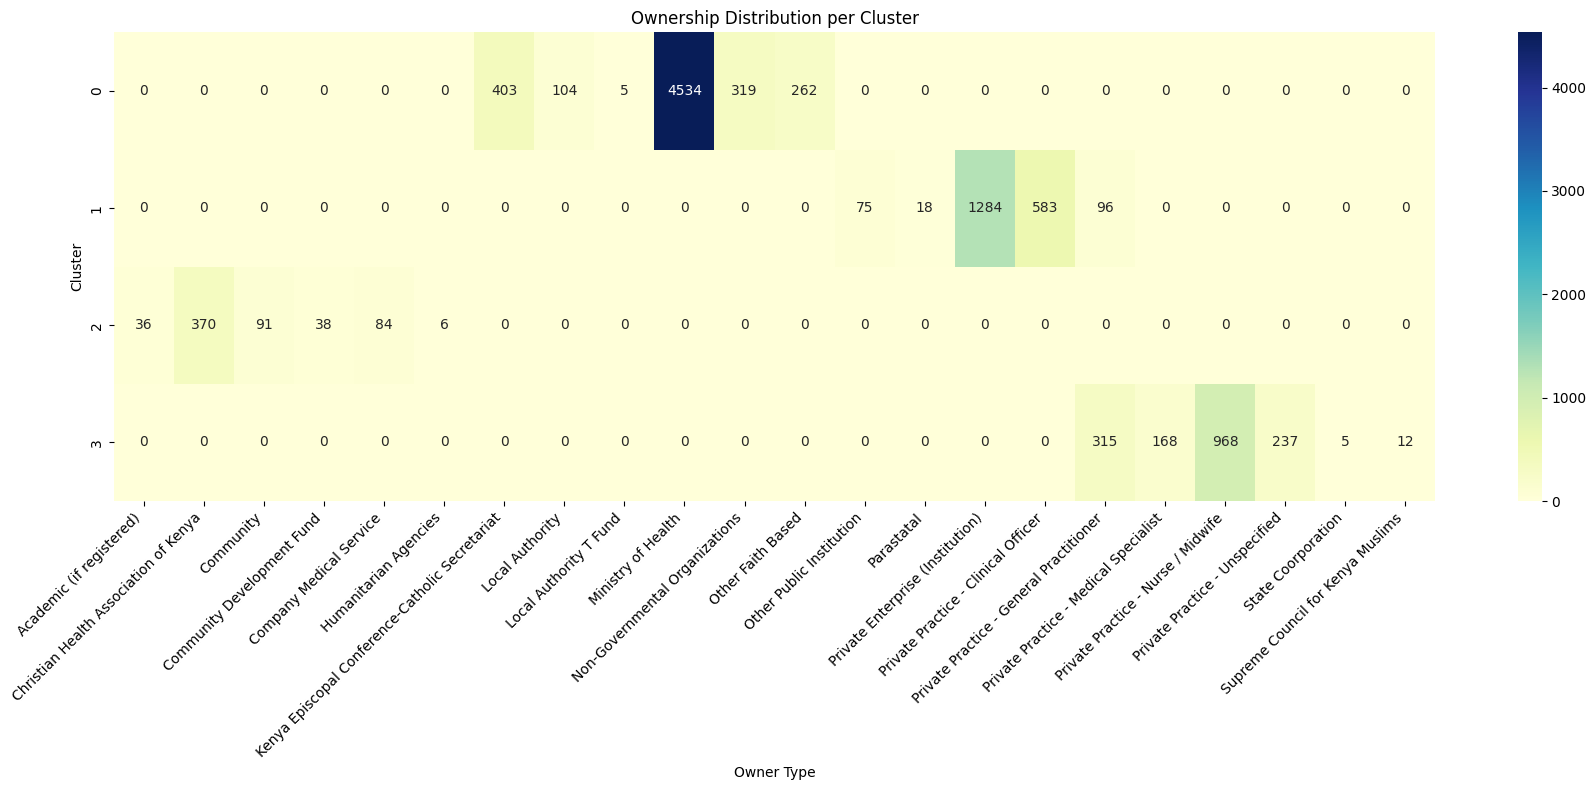

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
sns.heatmap(cluster_summary, cmap="YlGnBu", annot=True, fmt='g', cbar=True)
plt.title("Ownership Distribution per Cluster")
plt.xlabel("Owner Type")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [21]:

# Find top 3 owners per cluster
top_owners = cluster_summary.apply(lambda col: col[col > 0].sort_values(ascending=False).head(3))

print(top_owners)


Owner    Academic (if registered)  Christian Health Association of Kenya  \
Cluster                                                                    
0                             NaN                                    NaN   
1                             NaN                                    NaN   
2                            36.0                                  370.0   
3                             NaN                                    NaN   

Owner    Community  Community Development Fund  Company Medical Service  \
Cluster                                                                   
0              NaN                         NaN                      NaN   
1              NaN                         NaN                      NaN   
2             91.0                        38.0                     84.0   
3              NaN                         NaN                      NaN   

Owner    Humanitarian Agencies  \
Cluster                          
0                       

In [22]:
# Gradient-style view in notebook
cluster_summary.style.background_gradient(cmap='Oranges', axis=1).set_caption("Facility Ownership by Cluster")


Owner,Academic (if registered),Christian Health Association of Kenya,Community,Community Development Fund,Company Medical Service,Humanitarian Agencies,Kenya Episcopal Conference-Catholic Secretariat,Local Authority,Local Authority T Fund,Ministry of Health,Non-Governmental Organizations,Other Faith Based,Other Public Institution,Parastatal,Private Enterprise (Institution),Private Practice - Clinical Officer,Private Practice - General Practitioner,Private Practice - Medical Specialist,Private Practice - Nurse / Midwife,Private Practice - Unspecified,State Coorporation,Supreme Council for Kenya Muslims
Cluster,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,403,104,5,4534,319,262,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,75,18,1284,583,96,0,0,0,0,0
2,36,370,91,38,84,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,315,168,968,237,5,12
